## Libraries

In [1]:
import torch
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch import nn, optim
from torch.utils.data import DataLoader
from tqdm import tqdm                           # Progress bar
from torch.utils.data import random_split
import torchmetrics
from torchmetrics import Metric

import lightning as L                           # PyTorch Lightning
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.tuner import Tuner       # Hyperparameter tuning (example: lr_finder)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Dataset
Using the LightningDataModule

https://lightning.ai/docs/pytorch/stable/data/datamodule.html

MNIST Dataset loaded from:

https://pytorch.org/vision/stable/datasets.html

In [2]:
class MnistDataModule(L.LightningDataModule):
    def __init__(self, data_dir, batch_size, num_workers):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

    def prepare_data(self):
        datasets.MNIST(self.data_dir, train=True, download=True)
        datasets.MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage):
        entire_dataset = datasets.MNIST(
            root=self.data_dir,
            train=True,
            transform=transforms.ToTensor(),
            download=False,
        )
        self.train_ds, self.val_ds = random_split(entire_dataset, [50000, 10000])
        self.test_ds = datasets.MNIST(
            root=self.data_dir,
            train=False,
            transform=transforms.ToTensor(),
            download=False,
        )

    def train_dataloader(self):
        return DataLoader(
            self.train_ds,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
            persistent_workers=True,        # Considered to speed up the dataloader worker initialization
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_ds,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            persistent_workers=True,        # Considered to speed up the dataloader worker initialization
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_ds,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            persistent_workers=True,        # Considered to speed up the dataloader worker initialization
        )
    
    def predict_dataloader(self):
        return DataLoader(
            self.val_ds,                    # Use the entire validation dataset for prediction
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            persistent_workers=True,        # Considered to speed up the dataloader worker initialization
        )

## Model
Using the LightningModule

https://lightning.ai/docs/pytorch/stable/common/lightning_module.html

####  PyTorch Models

In [3]:
class FCN_4_layer(nn.Module):
    def __init__(self, input_size, num_classes, dropout_rate):
        super().__init__()
        self.input_size = input_size
        self.num_classes = num_classes
        self.dropout_rate = dropout_rate

        self.fc1 = nn.Linear(self.input_size, 250)
        self.fc2 = nn.Linear(250, 100)
        self.fc3 = nn.Linear(100, 100)
        self.fc4 = nn.Linear(100, self.num_classes)
        self.dropout = nn.Dropout(p=self.dropout_rate)



In [10]:
# Test the model
testmodel = FCN_4_layer(100, 3, 0.2)

x = torch.Tensor(range(100))
testmodel.forward(x)

tensor([ 2.9685, -4.4241, -1.6094], grad_fn=<ViewBackward0>)

#### LightningModule

In [135]:
class LightningModule(L.LightningModule):
    def __init__(self, input_size, learning_rate, num_classes, dropout_rate, dropout_samples):
        super().__init__()
        self.input_size = input_size
        self.lr = learning_rate
        self.num_classes = num_classes
        self.dropout_rate = dropout_rate
        self.dropout_samples = dropout_samples
        self.save_hyperparameters()
       
        # Define layers
        self.fc1 = nn.Linear(self.input_size, 250)
        self.fc2 = nn.Linear(250, 100)
        self.fc3 = nn.Linear(100, 100)
        self.fc4 = nn.Linear(100, self.num_classes)
        self.dropout = nn.Dropout(p=self.dropout_rate)
                
        # Loss function and metrics
        self.loss_fn = nn.CrossEntropyLoss()
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=self.num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x
    
    # Common step for training, validation, and test steps
    # To avoid code duplication
    def _common_step(self, batch, batch_idx):
        x, y = batch
        x = x.reshape(x.size(0), -1)
        scores = self.forward(x)
        loss = self.loss_fn(scores, y)
        accuracy = self.accuracy(scores, y)
        return loss, scores, y, accuracy

    def training_step(self, batch, batch_idx):
        loss, scores, y , accuracy = self._common_step(batch, batch_idx)
        self.log_dict({"train_loss": loss,"train_acc": accuracy},
                      on_step=False,
                      on_epoch=True,
                      prog_bar=True,
                      )
        return {"loss": loss, "scores": scores, "y": y}

    def validation_step(self, batch, batch_idx):
        loss, scores, y , accuracy = self._common_step(batch, batch_idx)
        self.log_dict({"val_loss": loss,"val_acc": accuracy},
                      on_step=False,
                      on_epoch=True,
                      prog_bar=True,
                      )
        return {"loss": loss, "scores": scores, "y": y}

    def test_step(self, batch, batch_idx):
        loss, scores, y , accuracy = self._common_step(batch, batch_idx)
        self.log_dict({"test_loss": loss,"test_acc": accuracy},
                      on_step=False,
                      on_epoch=True,
                      prog_bar=True,
                      )
        return {"loss": loss, "scores": scores, "y": y}

    # Prediction step applying Monte Carlo Dropout
    def predict_step(self, batch, batch_idx):
        x, y = batch
        x = x.reshape(x.size(0), -1)
        self.dropout.train() # Enable dropout
        predictions = torch.zeros(self.dropout_samples, x.size(0), self.num_classes)
        for i in range(self.dropout_samples):
            scores = self.forward(x)
            predictions[i] = scores
            # predictions[i] = F.softmax(scores, dim=1)
        return predictions

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.lr)

## Configuration

In [12]:
# Training hyperparameters
INPUT_SIZE = 784
NUM_CLASSES = 10
LEARNING_RATE = 0.001
DROPOUT_RATE = 0.4
MC_DROPOUT_SAMPLES = 50
BATCH_SIZE = 512
NUM_EPOCHS = 20

# Dataset
DATA_DIR = "dataset/"
NUM_WORKERS = 4

# Compute related
ACCELERATOR = "cpu"
DEVICES = 1

## Training
Using the Trainer

https://lightning.ai/docs/pytorch/stable/common/trainer.html

In [18]:
dm = MnistDataModule(data_dir=DATA_DIR,
                     batch_size=BATCH_SIZE,
                     num_workers=NUM_WORKERS,
                     )

In [136]:
model = LightningModule(input_size=INPUT_SIZE,
                        learning_rate=LEARNING_RATE,
                        num_classes=NUM_CLASSES,
                        dropout_rate=DROPOUT_RATE,
                        dropout_samples=MC_DROPOUT_SAMPLES,
                        )

In [49]:
model.hparams

"dropout_rate":    0.4
"dropout_samples": 50
"input_size":      784
"learning_rate":   0.001
"num_classes":     10

In [50]:
logger = CSVLogger("logs", name="FCM_MNIST")

trainer = L.Trainer(max_epochs=NUM_EPOCHS,
                    logger=logger,
                    )

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


#### Tuner - find hyperparameters

In [77]:
tuner = Tuner(trainer)

In [ ]:
# Use the learning rate finder to find the optimal learning rate
lr_finder = tuner.lr_find(model, train_dataloaders=dm)

# Plot the learning rate finder results
fig = lr_finder.plot(suggest=True)
fig.show()

In [79]:
# Find the maximum batch size that fits in memory
# In this case not necessary, because the dataset is small
# tuner.scale_batch_size(model, train_dataloaders=dm, steps_per_trial=1)

#### Training

In [56]:
trainer.fit(model, dm)


  | Name     | Type               | Params
------------------------------------------------
0 | fc1      | Linear             | 196 K 
1 | fc2      | Linear             | 25.1 K
2 | fc3      | Linear             | 10.1 K
3 | fc4      | Linear             | 1.0 K 
4 | dropout  | Dropout            | 0     
5 | loss_fn  | CrossEntropyLoss   | 0     
6 | accuracy | MulticlassAccuracy | 0     
------------------------------------------------
232 K     Trainable params
0         Non-trainable params
232 K     Total params
0.930     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


## Logged metrics

In [21]:
# Function to imoprt the metrics and plot them
# See '05_MC_Dropout_UC.ipynb' for more details
def plot_metrics(version):
    df = pd.read_csv(f"logs/FCM_MNIST/version_{version}/metrics.csv")
    df = df.groupby("epoch").median()

    fig, ax = plt.subplots(2, 1, figsize=(6, 6), sharex=True)

    ax[0].plot(df.index, df["train_loss"], label="training", color="r")
    ax[0].plot(df.index, df["val_loss"], label="validation", color="b")

    ax[1].plot(df.index, df["train_acc"], label="training", color="r")
    ax[1].plot(df.index, df["val_acc"], label="validation", color="b")
    ax[1].set_ylim(0, 1)

    ax[0].set_ylabel("Loss")
    ax[1].set_ylabel("Accuracy")
    ax[1].set_xlabel("Epoch")
    ax[0].legend()
    ax[1].legend()

    plt.tight_layout()
    plt.show()

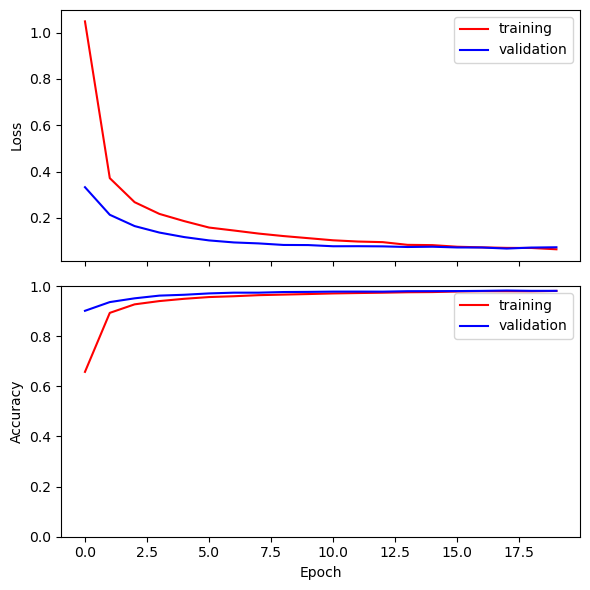

In [57]:
plot_metrics(9)

In [108]:
trainer.validate(model, dm)

Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9921000003814697     │
│         val_loss          │    0.02725714072585106    │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.02725714072585106, 'val_acc': 0.9921000003814697}]

## Make predictions and calculate uncertainty

In [137]:
# Load modelweights from checkpoint
model = LightningModule.load_from_checkpoint("logs/FCM_MNIST/version_9/checkpoints/epoch=19-step=1960.ckpt")

In [138]:
pred = trainer.predict(model, dm)

Predicting: |          | 0/? [00:00<?, ?it/s]

#### Step by step

In [139]:
# Create a tensor from the prediction list
predictions = pred[0]
predictions.shape

torch.Size([50, 512, 10])

In [140]:
# Calculate the mean softmax probabilities
# Take the class with the highest probability
idx_max = predictions.mean(dim=0).argmax(dim=1)

In [141]:
# Calculate the mean softmax probabilities
# Take the column of std according to the idx_max
softmax_max = predictions.mean(dim=0)[torch.arange(predictions.size(1)), idx_max]

In [142]:
# Calculate the standard deviation of the softmax probabilities
# Take the column of std according to the idx_max
std_max = predictions.std(dim=0)[torch.arange(predictions.size(1)), idx_max]

In [143]:
# Create a dataframe with the results
df = pd.DataFrame({"Prediction": idx_max.numpy(),
                   "Target":dm.test_ds.targets[0:BATCH_SIZE].numpy(),
                   "Softmax_UC": 1 - softmax_max.numpy(),
                   "Dropout_UC": std_max.numpy(),
                   })

df.head()

,Prediction,Target,Softmax_UC,Dropout_UC
0,0,7,-12.145341,3.566357
1,9,2,-9.003558,2.633237
2,3,1,-17.183716,4.836857
3,8,0,-11.111961,2.729129
4,5,4,-13.503737,4.157298


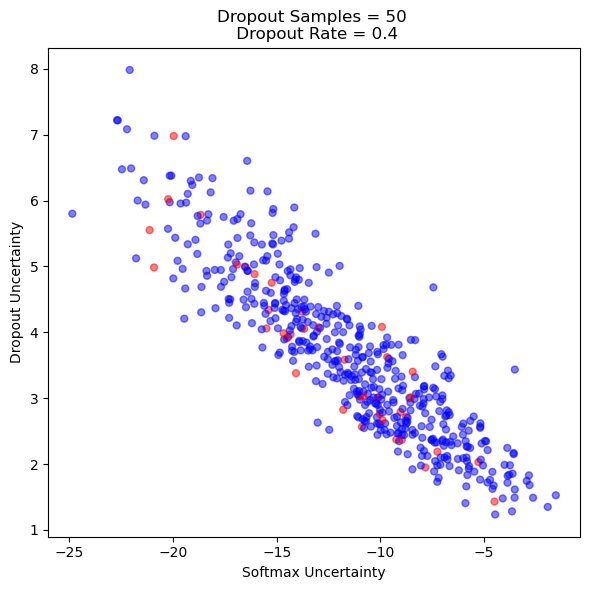

In [147]:
# Plot the Softmax_UC against the Dropout_UC
plt.figure(figsize=(6, 6))
plt.scatter(df["Softmax_UC"],
            df["Dropout_UC"],
            c=df["Prediction"] == df["Target"],
            cmap="bwr",
            alpha=0.5,
            s=25)

plt.xlabel("Softmax Uncertainty")
plt.ylabel("Dropout Uncertainty")
plt.title(f"Dropout Samples = {MC_DROPOUT_SAMPLES} \n Dropout Rate = {DROPOUT_RATE}")

# Scale both axes from 0 to 1
# plt.xlim(0, 1)
# plt.ylim(0, 1)

# Save the plot
plt.tight_layout()
plt.savefig(f"plots/Samples_{MC_DROPOUT_SAMPLES}_Rate_{DROPOUT_RATE}.png")

In [146]:
# Check the correlation between the Softmax_UC and the Dropout_UC
df[["Softmax_UC", "Dropout_UC"]].corr()

,Softmax_UC,Dropout_UC
Softmax_UC,1.000000,-0.900638
Dropout_UC,-0.900638,1.000000
